1. **연속 파동 방정식**:
$$
\frac{\partial^2 u}{\partial t^2} + \gamma \frac{\partial u}{\partial t} = c^2 \nabla^2 u
$$

2. **이산화된 업데이트 식**:
$$
u^{n+1}_{i,j} = \frac{2u^n_{i,j} - u^{n-1}_{i,j} + (c \Delta t)^2 \left( \frac{u^n_{i+1,j} + u^n_{i-1,j} + u^n_{i,j+1} + u^n_{i,j-1} - 4u^n_{i,j}}{\Delta x^2} \right) - \gamma \Delta t (u^n_{i,j} - u^{n-1}_{i,j})}{1 + \gamma \Delta t}
$$

3. **초기 조건**:
$$
u(x, y, t=0) = \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)
$$

4. **경계 조건**:
- Neumann: $u^{n+1}_{0,j} = u^{n+1}_{1,j}$, 등
- Dirichlet: $u^{n+1}_{i,j} = 0 \quad \text{if} \quad \text{game\_map}_{i,j} = 1$
- 투과 방지: $u^{n+1}_{i,j \pm 1} \leftarrow 0.1 \cdot u^{n+1}_{i,j \pm 1}$

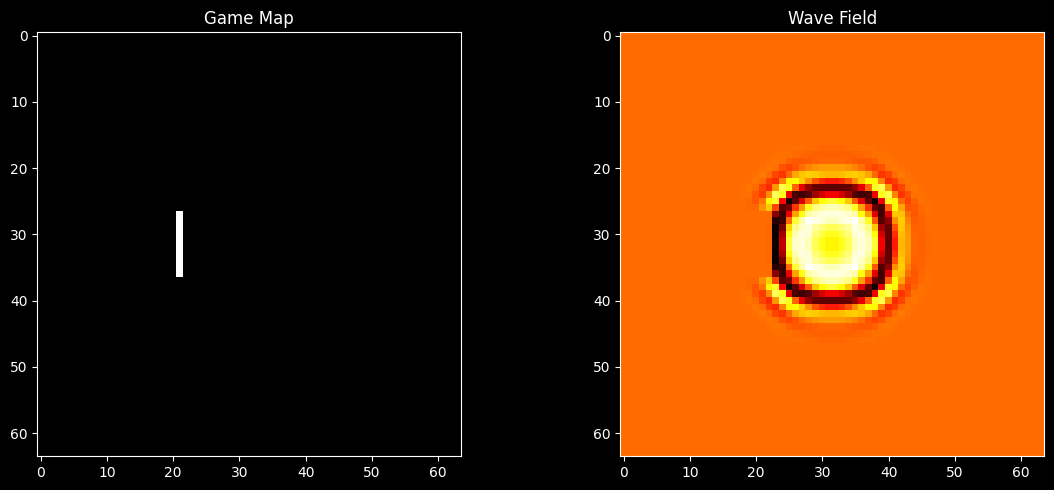

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from PIL.ImageOps import scale

# 설정
SIZE = 64
dx = 1.0
dt = 0.2
c = 1.0
gamma = 3.0  # 감쇠 계수
steps = 100

# 파동 필드 초기화
u = np.zeros((SIZE, SIZE))
u_prev = np.zeros((SIZE, SIZE))
u_next = np.zeros((SIZE, SIZE))

# Add single audio
x, y = np.meshgrid(np.linspace(-SIZE/2, SIZE/2, SIZE), np.linspace(-SIZE/2, SIZE/2, SIZE))
sigma = 1.0
u = np.exp(-(x**2 + y**2) / (2 * sigma**2))
u_prev = u.copy()

# Walls
game_map = np.zeros((SIZE, SIZE))
game_map[SIZE//2 - 5:SIZE//2 + 5, SIZE//3] = 1
c_map = c * (1 - game_map)

for t in range(steps):
    # Calculate waveform
    laplacian = (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
                 np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 4 * u) / dx**2
    u_next = (2 * u - u_prev + (c_map * dt)**2 * laplacian - gamma * dt * (u - u_prev)) / (1 + gamma * dt)

    # 경계 조건: 반사 (Neumann)
    u_next[0, :] = u_next[1, :]
    u_next[-1, :] = u_next[-2, :]
    u_next[:, 0] = u_next[:, 1]
    u_next[:, -1] = u_next[:, -2]

    # (Dirichlet)
    u_next[game_map == 1] = 0
    # (투과 방지)
    wall_indices = np.where(game_map == 1)
    for i, j in zip(wall_indices[0], wall_indices[1]):
        if j + 1 < SIZE:
            u_next[i, j+1] *= 0.1
        if j - 1 >= 0:
            u_next[i, j-1] *= 0.1

    u_prev = u.copy()
    u = u_next.copy()

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(game_map, cmap='gray')
ax[0].set_title('Game Map')
ax[1].imshow(u, cmap='hot', norm='symlog')
ax[1].set_title('Wave Field')
plt.tight_layout()

# print(f"Initial field max: {np.max(np.abs(u))}")
# print(f"Final field max: {np.max(np.abs(u))}")

plt.show()

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ========================== Parameters ==========================
SIZE = 100
dx = 1.0
dt = 0.1
c = 5.0
gamma = 0.1
steps = 350
channel_distance = 4 * dx

# ------------------- Sources -------------------
sources = [
    {"cx": -20, "cy": 12,  "sigma": 1.2, "vx": 5.0, "vy": 0.1, "freq": 0.8, "color": "lime"},
    # {"cx":  15, "cy": -8,  "sigma": 1.2, "vx": -1.20, "vy":  0.10, "freq": 0.6, "color": "cyan"},
]
source_amp = 0.15

# ------------------- Walls -------------------
game_map = np.zeros((SIZE, SIZE))
game_map[SIZE//2-6:SIZE//2+6, SIZE//3] = 1          # 수직 벽
c_map = c * (1 - game_map)

# ------------------- Listener -------------------
listener_row = SIZE // 5
listener_col = SIZE // 2
left_idx  = (listener_row, listener_col - 2)
right_idx = (listener_row, listener_col + 2)

grid_x, grid_y = np.meshgrid(np.linspace(-SIZE/2, SIZE/2, SIZE),
                             np.linspace(-SIZE/2, SIZE/2, SIZE), indexing='xy')

listener_x = grid_x[listener_row, listener_col]
listener_y = grid_y[listener_row, listener_col]
left_x,  left_y  = grid_x[left_idx[0],  left_idx[1]],  grid_y[left_idx[0],  left_idx[1]]
right_x, right_y = grid_x[right_idx[0], right_idx[1]], grid_y[right_idx[0], right_idx[1]]

# ------------------- Simulation -------------------
u = np.zeros((SIZE, SIZE))
u_prev = np.zeros((SIZE, SIZE))
wave_history = []
left_sig = []
right_sig = []

for t in range(steps):
    lap = (np.roll(u,  1, 0) + np.roll(u, -1, 0) +
           np.roll(u,  1, 1) + np.roll(u, -1, 1) - 4*u) / dx**2

    u_next = (2*u - u_prev + (c_map*dt)**2 * lap -
              gamma*dt*(u - u_prev)) / (1 + gamma*dt)

    for src in sources:
        cx = src["cx"] + src["vx"] * t * dt
        cy = src["cy"] + src["vy"] * t * dt
        phase = 2*np.pi * src["freq"] * t * dt
        pulse = source_amp * np.sin(phase) * np.exp(-((grid_x-cx)**2 + (grid_y-cy)**2)/(2*src["sigma"]**2))
        u_next += pulse

    # Boundary
    u_next[0, :]  = u_next[1, :]
    u_next[-1, :] = u_next[-2, :]
    u_next[:, 0]  = u_next[:, 1]
    u_next[:, -1] = u_next[:, -2]

    # Wall (Dirichlet)
    u_next[game_map == 1] = 0
    iwall, jwall = np.where(game_map == 1)
    for i, j in zip(iwall, jwall):
        for di, dj in [(0,1),(0,-1),(1,0),(-1,0)]:
            ni, nj = i+di, j+dj
            if 0 <= ni < SIZE and 0 <= nj < SIZE:
                u_next[ni, nj] *= 0.6

    u_prev = u.copy()
    u = u_next.copy()

    wave_history.append(u.copy())
    left_sig.append(u[left_idx])
    right_sig.append(u[right_idx])

left_sig  = np.array(left_sig)
right_sig = np.array(right_sig)

# ========================== Simple Cross-Correlation ==========================
def simple_cross_corr(sig1, sig2):
    corr = np.correlate(sig1, sig2, mode='full')
    mid = len(corr) // 2
    N = len(sig1)
    corr = corr[mid - N + 1 : mid + N]
    lags = np.arange(-N + 1, N) * dt
    return corr, lags

# ========================== Plot Setup (기본 스타일) ==========================
plt.rcParams.update(plt.rcParamsDefault)  # 기본 스타일 복구
fig, ax = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle("2D Wave Simulation + Real-time Sound Localization", fontsize=16)

extent = [-SIZE/2, SIZE/2, -SIZE/2, SIZE/2]

# 1. Map (기본 배경 + 회색 벽만)
ax[0,0].imshow(game_map, cmap='binary_r', extent=extent, alpha=0.6)
ax[0,0].plot(left_x,  left_y,  'o', mec='black', mew=1, mfc='red', ms=3, label="Left Ear")
ax[0,0].plot(right_x, right_y, 'o', mec='black', mew=1, mfc='blue', ms=3, label="Right Ear")
ax[0,0].plot(listener_x, listener_y, 'o', mec='black', mew=2, mfc='gold', ms=8)

src_markers = [ax[0,0].plot([], [], 'o', mec='black', mew=1, mfc=s["color"], ms=8)[0] for s in sources]

arrow = ax[0,0].arrow(listener_x, listener_y, 0, 0,
                      head_width=2, head_length=3, fc='green', lw=1.5)
theta_txt = ax[0,0].text(listener_x, listener_y + 10, "", color='black',
                         fontweight='bold', ha='center', va='bottom')

ax[0,0].set_xlim(-SIZE/2, SIZE/2)
ax[0,0].set_ylim(-SIZE/2, SIZE/2)
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title("Map & Estimated Direction")
ax[0,0].legend(loc="upper left")
ax[0,0].grid(True, alpha=0.3)

# 2. Wave Field (파장만 컬러로!)
im = ax[0,1].imshow(wave_history[0], cmap='RdBu', extent=extent,
                    vmin=-0.2, vmax=0.2, origin='lower', interpolation='bilinear')
ax[0,1].plot(left_x,  left_y,  'o', mec='black', mew=1, mfc='red',  ms=5)
ax[0,1].plot(right_x, right_y, 'o', mec='black', mew=1, mfc='blue', ms=5)
ax[0,1].set_title("Wave Field")
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")

# 3. Binaural Signals
time_ax = np.arange(steps) * dt
l_line, = ax[1,0].plot([], [], 'r-', lw=1.8, label="Left Ear")
r_line, = ax[1,0].plot([], [], 'b-', lw=1.8, label="Right Ear")
ax[1,0].set_xlim(0, steps*dt)
ax[1,0].set_ylim(-0.28, 0.28)
ax[1,0].set_xlabel("Time (s)")
ax[1,0].set_ylabel("Amplitude")
ax[1,0].set_title("Binaural Signals")
ax[1,0].legend()
ax[1,0].grid(True, alpha=0.3)

# 4. Cross-Correlation
corr_line, = ax[1,1].plot([], [], 'k', lw=2)
peak_line = ax[1,1].axvline(0, color='orange', lw=3, label="Estimated τ")
ax[1,1].axvline(0, color='gray', ls='--', alpha=0.7)
ax[1,1].set_xlim(-1.2, 1.2)
ax[1,1].set_ylim(-50, 300)
ax[1,1].set_xlabel("Time Difference τ (s)")
ax[1,1].set_title("Cross-Correlation")
ax[1,1].legend()
ax[1,1].grid(True, alpha=0.3)

def update(frame):
    t = frame + 1
    im.set_array(wave_history[frame])

    for i, src in enumerate(sources):
        cx = src["cx"] + src["vx"] * frame * dt
        cy = src["cy"] + src["vy"] * frame * dt
        src_markers[i].set_data([cx], [cy])

    l_line.set_data(time_ax[:t], left_sig[:t])
    r_line.set_data(time_ax[:t], right_sig[:t])

    if t >= 30:
        cc, lags = simple_cross_corr(left_sig[:t], right_sig[:t])
        peak_idx = np.argmax(cc)
        tau = lags[peak_idx]

        corr_line.set_data(lags, cc)
        peak_line.set_xdata([tau, tau])
        ax[1,1].set_ylim(np.min(cc)*1.1, np.max(cc)*1.1 + 10)

        # 정확한 부호: 왼쪽 소리 → tau > 0 → 각도는 음수
        sin_theta = tau * c / channel_distance
        sin_theta = np.clip(sin_theta, -1, 1)
        theta_rad = np.arcsin(sin_theta)

        arrow.set_data(x=listener_x, y=listener_y,
                       dx=32*np.cos(theta_rad), dy=32*np.sin(theta_rad))
        theta_txt.set_text(f"{np.degrees(theta_rad):+5.1f}°")
    else:
        corr_line.set_data([], [])
        peak_line.set_xdata([0])
        arrow.set_data(dx=0, dy=0)
        theta_txt.set_text("")

    return [im, l_line, r_line, corr_line, peak_line, arrow, theta_txt] + src_markers

ani = FuncAnimation(fig, update, frames=steps, interval=50, blit=False)

# ani.save("moving_sound_tdoa.gif", writer="pillow", fps=25)
# ani.save("tdoa.mp4", writer="ffmpeg", fps=30)

# HTML(ani.to_jshtml())
plt.close(fig)

/home/kar7mp5/PycharmProjects/Linear-Algebra-Study/.venv/lib/python3.10/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


### Path finding

I would change path finding algorithm BFS to A* algorithm.

1. 연속 파동 방정식
$$
\frac{\partial^2 u}{\partial t^2} + \gamma \frac{\partial u}{\partial t} = c^2 \nabla^2 u
$$

2. 이산화된 업데이트 식
$$
u^{n+1}_{i,j} = \frac{2u^n_{i,j} - u^{n-1}_{i,j} + (c \Delta t)^2 \left( \frac{u^n_{i+1,j} + u^n_{i-1,j} + u^n_{i,j+1} + u^n_{i,j-1} - 4u^n_{i,j}}{\Delta x^2} \right) - \gamma \Delta t (u^n_{i,j} - u^{n-1}_{i,j})}{1 + \gamma \Delta t}
$$

3. 초기 조건
$$
u(x, y, t=0) = \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)
$$

4. 경계 조건
- Neumann: $u^{n+1}_{0,j} = u^{n+1}_{1,j}$, 등
- Dirichlet: $u^{n+1}_{i,j} = 0 \quad \text{if} \quad \text{game\_map}_{i,j} = 1$
- 투과 방지: $u^{n+1}_{i,j \pm 1} \leftarrow 0.1 \cdot u^{n+1}_{i,j \pm 1}$

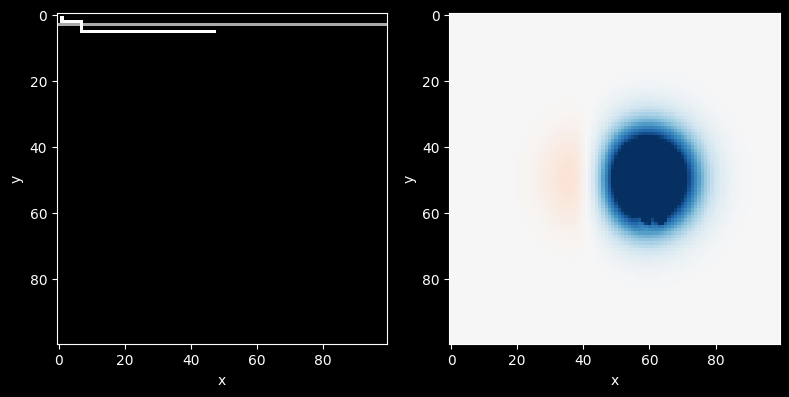

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque


class Simulation:
    def __init__(self, width, height, times=100):
        # Parameter setting
        self.WIDTH, self.HEIGHT = width, height
        self.times = times

        # Game map
        self.game_map = np.zeros((self.WIDTH, self.HEIGHT))

        # Waveform
        self.u = np.zeros((self.WIDTH, self.HEIGHT))
        self.u_prev = np.zeros((self.WIDTH, self.HEIGHT))

        # Sound origins
        self.sources = [
            {"cx": 10, "cy": 12,  "sigma": 1.2, "vx": 1.25, "vy": -0.05, "freq": 0.8, "color": "lime"},
            {"cx":  0, "cy": 0,  "sigma": 10.0, "vx": 3.25, "vy":  0, "freq": 0.5, "color": "cyan"},
        ]

        self.wave_history = []

    def waveform(self, times: int) -> np.ndarray:
        """Waveform function

        Args:
            times (int): number of time steps

        Returns:
            np.ndarray: waveform
        """
        dx = 1.0
        dt = 0.1
        c = 1.0
        gamma = 0.3  # 감쇠 계수
        c_map = c * (1 - self.game_map)
        source_amp = 0.15

        grid_x, grid_y = np.meshgrid(np.linspace(-self.WIDTH/2, self.WIDTH/2, self.WIDTH),
                                     np.linspace(-self.HEIGHT/2, self.HEIGHT/2, self.HEIGHT))

        for t in range(times):
            lap = (np.roll(self.u,  1, 0) + np.roll(self.u, -1, 0) +
                   np.roll(self.u,  1, 1) + np.roll(self.u, -1, 1) - 4*self.u) / dx**2

            u_next = (2*self.u - self.u_prev + (c_map*dt)**2 * lap -
                      gamma*dt*(self.u - self.u_prev)) / (1 + gamma*dt)

            for src in self.sources:
                # Position
                cx = src["cx"] + src["vx"] * t * dt
                cy = src["cy"] + src["vy"] * t * dt
                phase = 2*np.pi * src["freq"] * t * dt
                pulse = source_amp * np.sin(phase) * np.exp(-((grid_x-cx)**2 + (grid_y-cy)**2)/(2*src["sigma"]**2))
                u_next += pulse

            # Boundary
            u_next[0, :]  = u_next[1, :]
            u_next[-1, :] = u_next[-2, :]
            u_next[:, 0]  = u_next[:, 1]
            u_next[:, -1] = u_next[:, -2]

            # Wall (Dirichlet)
            u_next[self.game_map == 1] = 0
            iwall, jwall = np.where(self.game_map == 1)
            for i, j in zip(iwall, jwall):
                for di, dj in [(0,1),(0,-1),(1,0),(-1,0)]:
                    ni, nj = i+di, j+dj
                    if 0 <= ni < SIZE and 0 <= nj < SIZE:
                        u_next[ni, nj] *= 0.6

            self.u_prev = self.u.copy()
            self.u = u_next.copy()
            self.wave_history.append(self.u.copy())

    # Game map function
    def bfs(self, grid, start_x, start_y, end_x, end_y):
        dx = [-1, 1, 0, 0]
        dy = [0, 0, -1, 1]

        grid[start_x][start_y] = 1
        # grid[end_x][end_y] = 0

        queue = deque([(start_x, start_y, [(start_x, start_y)])])  # (row, col, path)
        visited = set([(start_x, start_y)])

        while queue:
            r, c, path = queue.popleft()

            if r == end_x and c == end_y:
                return path

            for i in range(4):
                nx, ny = r + dx[i], c + dy[i]

                if 0 <= nx < self.WIDTH and 0 <= ny < self.HEIGHT and grid[nx][ny] == 0 and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append((nx, ny, path + [(nx, ny)]))

        return None

    def _print_map(self, grid: list) -> None:
        for x in range(self.WIDTH):
            for y in range(self.HEIGHT):
                print(grid[i][j], end=' ')
            print()


    def run(self):
        start_x, start_y = 1, 1
        end_x, end_y = 5, 47

        # print_map(game_map)
        self.game_map[3, ::] = 2
        self.game_map[3, 7] = 0

        path = self.bfs(self.game_map, start_x, start_y, end_x, end_y)

        # Path exist
        if path is None:
            print("Failed to find path")
        else:
            for (x, y) in path:
                self.game_map[x][y] = 3
        # print('='*25)
        # print_map(game_map)

        self.waveform(self.times)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(self.game_map, cmap='gray')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')

        ax[1].imshow(self.u, cmap='RdBu', norm='symlog', vmin=-1, vmax=1)
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')

        plt.tight_layout()
        plt.show()

        # print(len(self.wave_history))
        # for im in self.wave_history:
        #     plt.imshow(im, cmap='RdBu')
        #     plt.show()

simulation = Simulation(width=100, height=100, times=35)
simulation.run()